# White wine quality classification using Machine Learning

## Libraries Import

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import scipy as scipy
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import warnings
warnings.filterwarnings('ignore')


# Data mining for white wine quality assessment

### 1. *SEARCH HYPOTHESIS*

Wine has been consumed as an alcoholic beverage for thousands of years, and wine production and trade have benefited greatly from the evaluation of wine quality. It is a multifactorial task made by intrinsic characteristics (visual, taste, smell), environmental (climate, region, site), management practices (viticultural practice) and physicochemical ingredients (acid, pH, etc.). At least in part, scores are subjective to individual expertise, experience and interpretation.

In this work, a scientific data analysis approach has been adopted to classify wines into different quality categories based on a set of measured physicochemical properties.

### 2. *DATA COLLECTION*

The ‘Wine Quality Dataset’ is publicly available in the UCI Machine Learning Repository [https://archive.ics.uci.edu/dataset/186/wine+quality]. It consists of two separate datasets – one for red wine (consisting of 1,599 instances) and one for white wine (consisting of 4,898 instances). Both datasets contain eleven attributes capturing a specific wine sample physicochemical property, as well as a quality score between 0 and 9, with a score of ‘0’ representing lowest wine sample quality.

In [128]:
white = pd.read_csv("/Users/hassan/Downloads/winequality-white.csv", sep=';')

The available attributes are: 
+ (1) Fixed Acidity (fresh, tart and sour attributes);
+ (2) Volatile Acidity (volatile organic acids, i.e., acetic acid, spoilage);
+ (3) Citric Acid (nonvolatile acid, freshness);
+ (4) Residual Sugar (sugar remaining after fermentation process);
+ (5) Chlorides (amount of salt in the wine);
+ (6) Free Sulfur Dioxide (amount of free form of dioxide gas (S02) preventing microbial growth and the oxidation of wine);
+ (7) Total Sulfur Dioxide (amount of free forms of sulfur dioxide gas (S02));
+ (8) Density (density of water based on alcohol and sugar levels);
+ (9) pH level ((0–14) of acidity or alkalinity of a solution. Most wines are between 3.3–3.7);
+ (10) Sulphates (wine additive, contributes to dioxide gas (S02) gas levels);
+ (11) Alcohol percentage (% of alcohol present);
+ (12) Output - **quality score**, which is a numeric, ordered value. 

All attributes, except for quality which is int64, are float64.

In [129]:
print(white.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
None


### 3. *METHODOLOGY*


After the data import. EDA, data pre-processing & Synthetic Minority Over-Sampling Technique (SMOTE), to oversample the minority class. Then a classifier that divides wine into three categories —high quality, normal quality, and low quality— was modeled using the balanced data.

#### 3.1 DATA CLEANING AND PRE-PROCESSING

In [130]:
white.isna().sum() # Check for null values

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [131]:
white.isna().sum().sum()

0

There are no missing values in the dataset. 

**DUPLICATES**

Now let's remove any complete **duplicates** in the dataframe to avoid possible 
overfitting and enhance results' reliability.


In [132]:
length1 = len(white)
white.drop_duplicates(keep=False, inplace=True)
length2 = len(white)
n_duplicati = length1 - length2

In [133]:
data = {
    "Original df's len": [length1],
    "No duplicates df's len": [length2],
    "Duplicates": [n_duplicati]
}
df = pd.DataFrame(data, index=['']).T

df

,
Original df's len,4898
No duplicates df's len,3189
Duplicates,1709


**OUTLIERS HANDLING**

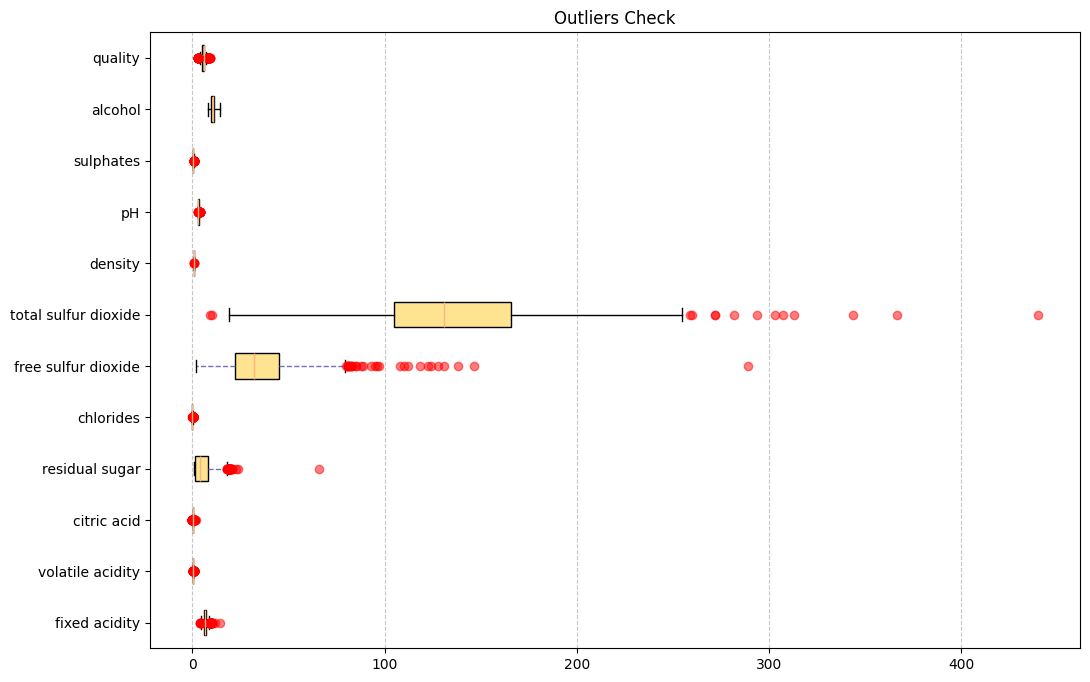

In [134]:
sns.set_palette("pastel")

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Outliers Check')

# Convert to numeric and handle NaN
boxplot_data = white.apply(pd.to_numeric, errors='coerce').values
boxplot_data = np.nan_to_num(boxplot_data)

# Get the column names for labeling
column_names = white.columns

# Plot the horizontal boxplot with labels
boxplot = ax.boxplot(boxplot_data, labels=column_names, vert=False, patch_artist=True)

# Customize box colors
for box in boxplot['boxes']:
    box.set(facecolor='#fee390') 

# Customize whisker and flier colors
for whisker, flier in zip(boxplot['whiskers'], boxplot['fliers']):
    whisker.set(color='#7570b3', linestyle='--')
    flier.set(marker='o', markerfacecolor='red', markeredgecolor='red', alpha=0.5)

# Horizontal grid lines
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


Visually, we can see important presence of outliers in a few columns. So we'll remove them from the dataset with the Z-Score Method:

- Calculate the z-score for each data point in the dataset [(x - mean_value) / std_dev for x in data].
- Set a threshold (e.g., z-score > 3 or z-score < -3) to identify outliers.
- Remove data points that exceed the threshold.

In [135]:
# Exclude the last three columns from z-score calculation
z_scores = np.abs(zscore(white.iloc[:, :-3]))

# Create a mask to identify outliers
outlier_mask = (z_scores < 3).all(axis=1)

# Select rows without outliers
white = white[outlier_mask]


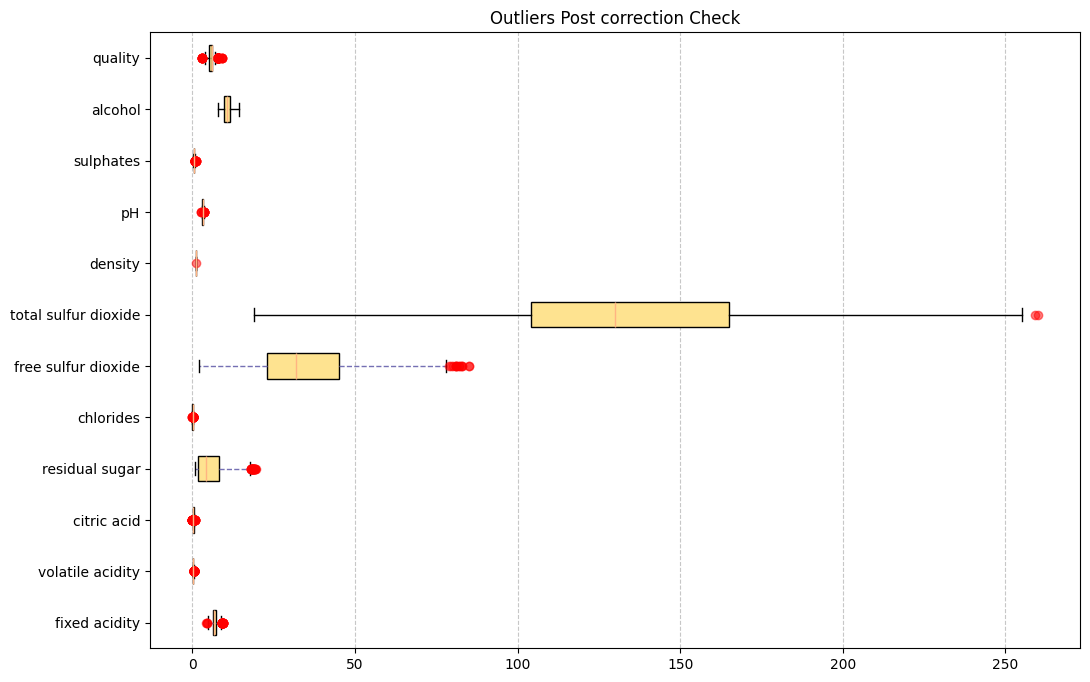

In [136]:
sns.set_palette("pastel")

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Outliers Post correction Check')

# Convert to numeric and handle NaN
boxplot_data = white.apply(pd.to_numeric, errors='coerce').values
boxplot_data = np.nan_to_num(boxplot_data)

# Get the column names for labeling
column_names = white.columns

# Plot the horizontal boxplot with labels
boxplot = ax.boxplot(boxplot_data, labels=column_names, vert=False, patch_artist=True)

# Customize box colors
for box in boxplot['boxes']:
    box.set(facecolor='#fee390')

# Customize whisker and flier colors
for whisker, flier in zip(boxplot['whiskers'], boxplot['fliers']):
    whisker.set(color='#7570b3', linestyle='--')
    flier.set(marker='o', markerfacecolor='red', markeredgecolor='red', alpha=0.5)

# Horizontal grid lines
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


**UNIVARIATE ANALYSIS & DESCRIPTIVE STATISTICS**

**FROM 0-9 TO QUALITY'S CLASSES**

Let's make things simple and reduce the ratings for quality to three levels as high, normal and low.

Subsetting in three labels:
- ratings 3, 4 : wine quality is "low";
- ratings 5, 6, 7 : wine quality is "medium";
- ratings 8, 9 : wine quality is "high".

In [137]:
white['quality label'] = white['quality'].apply(lambda x: 'low' if x<=5 else 'medium' if x<8 else 'high')


# Reducing the quality ratings to [0,1,2] where 0 = low, 1 = normal, and 2 = high. 
# Creating function to label quality ratings. 
def label_quality(row):
  if row["quality"] <= 5:
    return 0
  elif row["quality"] >= 8:
    return 2
  else:
    return 1

white["quality_check"] = white.apply(lambda row: label_quality(row), axis=1) 

                       count
quality quality label       
3       low               12
4       low              115
5       low              821
6       medium          1356
7       medium           539
8       high              97
9       high               5


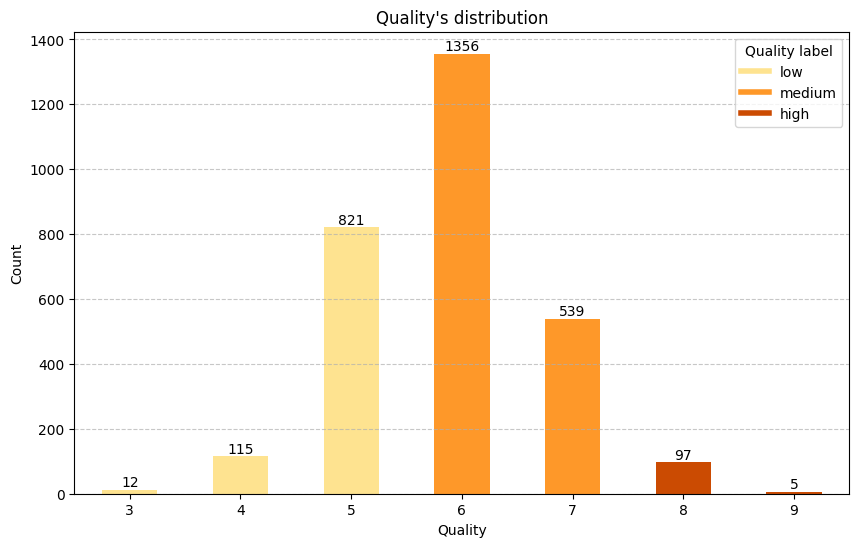

In [138]:
df_counts = pd.DataFrame(white[['quality','quality label']].value_counts().sort_index().T)
print(df_counts)

df_counts = white[['quality', 'quality label']].value_counts().sort_index()

# Creating a colormap with seven different shades of yellow
colors = ['#fee390','#fee390','#fee390','#fe9829','#fe9829','#cb4b02','#cb4b02']

# Plotting
ax = df_counts.plot(kind='bar', figsize=(10, 6), color=colors, legend=False)
plt.title("Quality's distribution")
plt.xlabel('Quality')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding a custom legend for each label
colors2 = sns.color_palette("YlOrBr", n_colors=3)
legend_labels = ['low', 'medium', 'high']
legend_handles = [plt.Line2D([0], [0], color=colors2[i], lw=4, label=legend_labels[i]) for i in range(3)]
ax.legend(handles=legend_handles, title='Quality label', loc='upper right')

ax.set_xticks(range(len(df_counts)))
ax.set_xticklabels(df_counts.index.get_level_values('quality'), rotation=0)



for i, v in enumerate(df_counts.values.flatten()):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)


In [139]:
df_counts = pd.DataFrame(white['quality label'].value_counts())

# Add a percentage column
df_counts['%'] = round((df_counts['count'] / df_counts['count'].sum()) * 100,1)

# Print or use the DataFrame as needed
df_counts = pd.DataFrame(df_counts)

df_counts

,count,%
quality label,,
medium,1895,64.3
low,948,32.2
high,102,3.5


One of the problems this particular data set presents is that the classes are imbalanced — 64.3% of the instances are from medium class, 32.2% from the low class and only 3,5 % are from the high quality class. The models built based on this data set may be over-fitting in favor of the majority class. So after the data splitting and before the modelling, we applied the Synthetic Minority Over- Sampling Technique (SMOTE) to over overcome this problem in the data preparation stage.

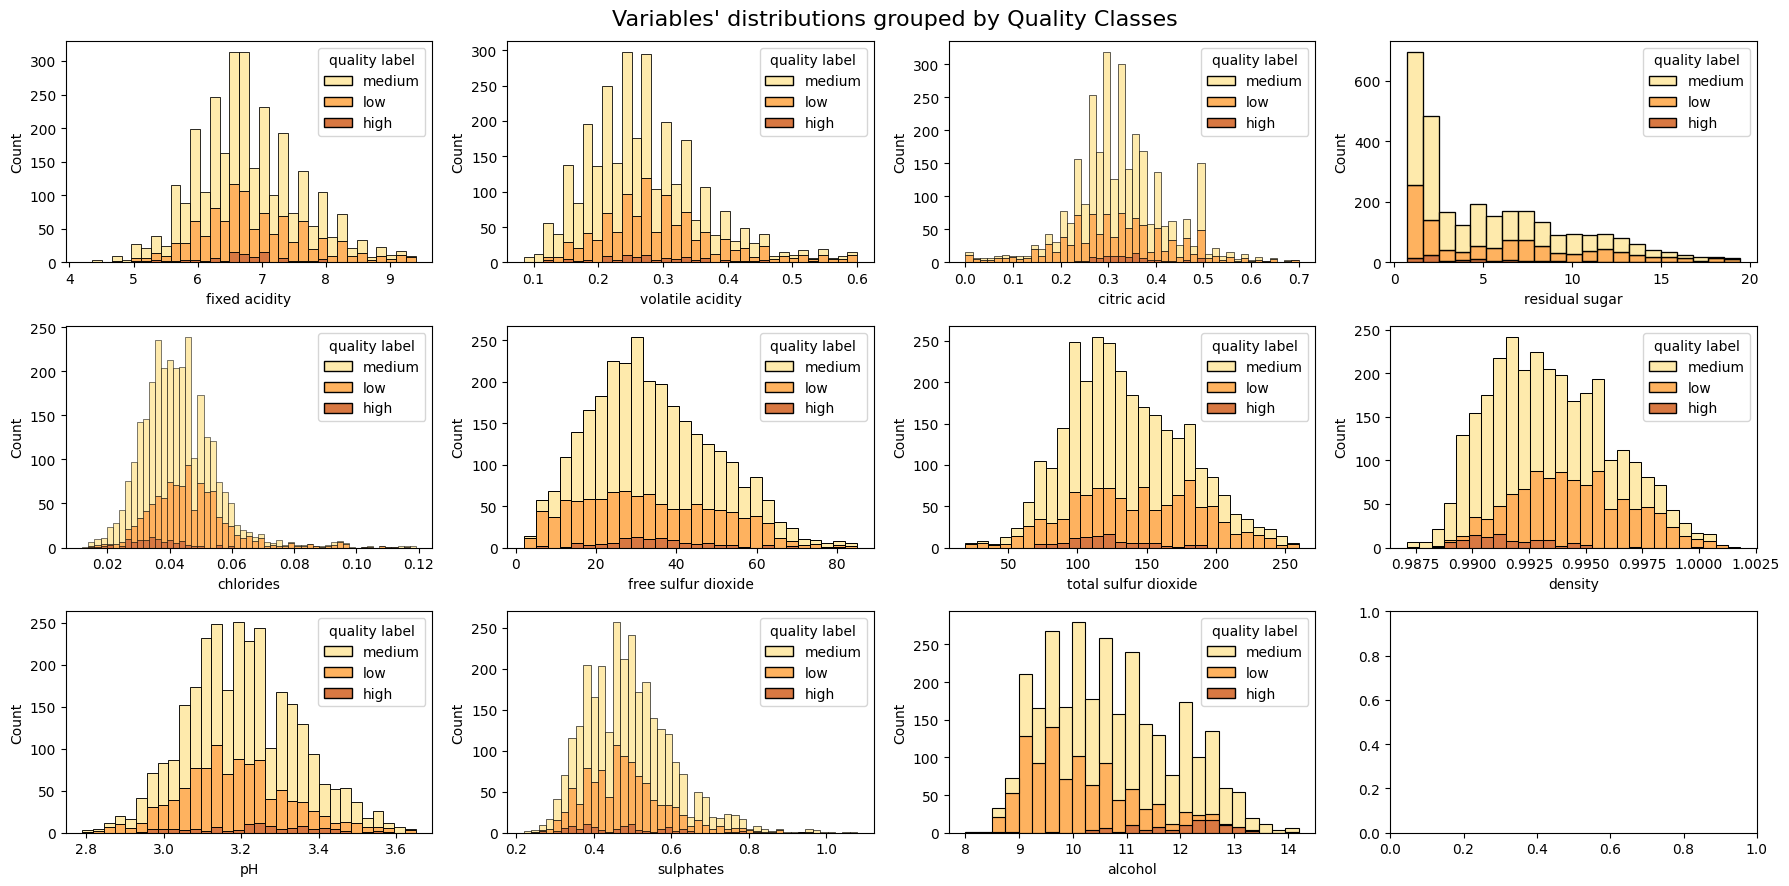

In [140]:
custom_palette = sns.color_palette("YlOrBr", n_colors=3)

req_cols = white.columns[:-2].values
f, ax1 = plt.subplots(3, 4, figsize=(18, 9))
counter = 0

for r in range(3):
    for c in range(4):
        if counter > 10:
            continue
        sns.histplot(data=white, x=req_cols[counter], hue='quality label', stat='count', multiple='stack',
                     ax=ax1[r][c], palette=custom_palette)
        counter += 1

plt.suptitle("Variables' distributions grouped by Quality Classes", fontsize=16)

f.tight_layout()
plt.show()


In [141]:
custom_palette = sns.light_palette("#fee390", as_cmap=True)
styled_df = white.describe()[1:].T.style.format("{:.1f}").background_gradient(cmap=custom_palette)
styled_df

,mean,std,min,25%,50%,75%,max
fixed acidity,6.8,0.8,4.2,6.2,6.7,7.3,9.4
volatile acidity,0.3,0.1,0.1,0.2,0.3,0.3,0.6
citric acid,0.3,0.1,0.0,0.3,0.3,0.4,0.7
residual sugar,5.4,4.4,0.7,1.6,4.3,8.1,19.4
chlorides,0.0,0.0,0.0,0.0,0.0,0.0,0.1
free sulfur dioxide,34.0,15.6,2.0,23.0,32.0,45.0,85.0
total sulfur dioxide,135.0,42.1,19.0,104.0,130.0,165.0,260.0
density,1.0,0.0,1.0,1.0,1.0,1.0,1.0
pH,3.2,0.1,2.8,3.1,3.2,3.3,3.6
sulphates,0.5,0.1,0.2,0.4,0.5,0.6,1.1


**DATA STANDARDIZATION**

*StandardScaler* is a preprocessing class from scikit-learn that standardizes features by removing the mean and scaling to unit variance. This means that after applying the StandardScaler, the transformed data will have a mean of 0 and a standard deviation of 1.

In [143]:
cols_to_scale = white.columns[:-3]  # Excluding the last three columns from scaling

scaler = StandardScaler()
white[cols_to_scale] = scaler.fit_transform(white[cols_to_scale])

white.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality label,quality_check
6,-0.722273,0.511993,-1.635364,0.351558,0.162752,-0.253963,0.024209,0.532301,-0.161490,-0.186424,-0.918223,6,medium,1
9,1.565766,-0.600215,1.042532,-0.893287,0.082507,-0.381988,-0.142092,0.119728,0.117570,-0.364618,0.258423,6,medium,1
10,1.565766,-0.044111,0.844169,-0.904604,-0.800188,-1.470201,-1.710077,-1.005471,-1.487026,0.615452,1.098884,5,low,0


**CORRELATION ANALYSIS**

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables. The value is in the range of -1 to 1. If two variables have a high correlation, we can neglect one variable from those two.

In [144]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming white is your DataFrame
white_subset = white.iloc[:, :-2]
corr = white_subset.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan

# Create a Styler object
styled_corr = (corr
               .style
               .background_gradient(cmap='YlOrBr', axis=None, vmin=-1, vmax=1)
               .highlight_null(color='#f1f1f1')  # Color NaNs grey
               .format(precision=2))

# Set the title using set_caption
styled_corr.set_caption("Pearson Correlation Heatmap of Features")

styled_corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
volatile acidity,-0.06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
citric acid,0.32,-0.21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
residual sugar,0.06,0.10,0.10,nan,nan,nan,nan,nan,nan,nan,nan,nan
chlorides,0.08,0.05,0.03,0.17,nan,nan,nan,nan,nan,nan,nan,nan
free sulfur dioxide,-0.07,-0.10,0.10,0.37,0.13,nan,nan,nan,nan,nan,nan,nan
total sulfur dioxide,0.06,0.11,0.12,0.44,0.30,0.62,nan,nan,nan,nan,nan,nan
density,0.25,0.03,0.14,0.79,0.42,0.34,0.58,nan,nan,nan,nan,nan
pH,-0.40,-0.04,-0.18,-0.15,-0.01,-0.03,0.01,-0.02,nan,nan,nan,nan
sulphates,-0.02,-0.02,0.07,-0.02,0.07,0.01,0.13,0.09,0.11,nan,nan,nan


We can see that some attributes are pairwise highly correlated (e.g free sulfur dioxide and total sulfur dioxide 0.62, residual sugar and density 0.79 density and total sulfur dioxide 0.58, density and alcool -0.79), which makes classifying them harder.

The attribute that is the most correlated to the label (quality) is alcohol.

We'll drop the attribute 'total sulfur dioxide' and 'density'

#### 3.3 Input Splitting

In [145]:
# if I want to drop density

# y = white['quality_check'] #outcome
# X = white.drop(columns= ['density','quality', 'quality label', 'quality_check'],axis=1) #remove outcome + drop density

In [228]:
# if I want to drop total sulfure dioxide and density

y = white['quality_check'] #outcome
X = white.drop(columns= ['total sulfur dioxide','density','quality', 'quality label', 'quality_check'],axis=1) #remove outcome + drop density

#### 3.4 Class Imbalance Handling (SMOTE)

The Synthetic Minority Oversampling Technique (SMOTE)
is an over-sampling method to address the problem of imbalanced distribution of data. The basic idea is to re-sample the data space to create more synthetic points of the rare class.
Here is how the basic SMOTE algorithm works. Let D be the data set, R ⊂ D be the set of minority class. The algorithm iterates through for each r ∈ R, identifies the k
nearest neighbor N of r based on some distance measure, where k is a parameter. Then, the algorithm randomly picks a point n ∈ N, interpolating between r and n to create a
synthetic point p. The new point p is to be added to the
minority class. This is illustrated in Fig. 2, where 2(a) shows
the two classes (minority class has only one point) and 2(b)
shows the 4 nearest neighbors of the minority point and the
newly generated synthetic point by SMOTE.

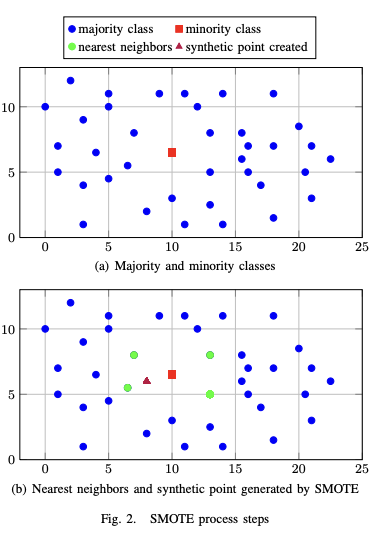

In [229]:
# Class distribution before SMOTE
class_distribution_before = Counter(y)

# Apply SMOTE to the data
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Class distribution after SMOTE
class_distribution_after = Counter(y_smote)

# Create a DataFrame
class_distribution_df = pd.DataFrame({
    'Q class': list(class_distribution_before.keys()),
    'Before SMOTE': list(class_distribution_before.values()),
    'After SMOTE': list(class_distribution_after.values())
})

# Display the DataFrame
print("     Class distribution counts:",)
class_distribution_df

     Class distribution counts:


,Q class,Before SMOTE,After SMOTE
0,1,1895,1895
1,0,948,1895
2,2,102,1895


#### 3.5 Model Training:

Four machine learning methods were used in our study. A
model was built using each method and applied to the original
imbalanced data and the balanced data after SMOTE. It was also added a k-fold cross-validation for both to have a more robust assessment of each model's performance, improving the effective use of data, and promoting better generalization to new data.
Basic ideas of the methods are given here:

- *Decision Tree* (**DT**):
Decision tree is a supervised machine (labeled dataset) learning algorithm that can be used for both classification and regression tasks. It works by recursively partitioning the input space into regions and assigning a predictive model to each region. In classification tasks, each leaf of the tree corresponds to a specific class. The algorithm makes decisions based on input features, splitting the data into subsets at each node of the tree, ultimately leading to leaves that represent the predicted output.

- *K-Nearest Neighbors* (**KNN**):
It is a is a supervised instance-based or "lazy learning" learning algorithm, as it doesn't build an explicit model during training. Instead, it memorizes the training instances.
In a classification task, given a new, unseen data point, KNN classifies it by comparing it to the k-nearest neighbors in the training dataset. The class that is most common among its k-nearest neighbors is assigned to the new data point.
k = 5 in default.

- *Random Forest* (**RF**):
Random Forest is an esemble-supervised learning algorithm, that operates by constructing a multitude of decision trees during training and outputs the mode (classification) or mean (regression) prediction of the individual trees for a given input. Ensemble methods utilize multiple learning algorithms to obtain better predictive perfor-mance that can not be obtained by using a simple learning algorithm.

- *Extra Trees* (Extremely Randomized Trees - **ERT**):
It is an ensemble learning method that builds a collection of decision trees and combines their predictions.

In [230]:
def classify(model, X, y, X_smote, y_smote):
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    x_train_smote, x_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.25, random_state=42)
    
    # Train the model
    model.fit(x_train, y_train)
    accuracy = model.score(x_test, y_test) * 100

    # Train the model with SMOTE
    model.fit(x_train_smote, y_train_smote)
    accuracy_smote = model.score(x_test_smote, y_test_smote) * 100
    
    # Cross-validation
    score = cross_val_score(model, X, y, cv=5)
    cv_score = np.mean(score) * 100

    # Cross-validation with SMOTE
    score_smote = cross_val_score(model, X_smote, y_smote, cv=5)
    cv_score_smote = np.mean(score_smote) * 100

    return {
        'Accuracy': accuracy,
        'Accuracy with SMOTE': accuracy_smote,
        'CV Score': cv_score,
        'CV Score with SMOTE': cv_score_smote,
    }

In [231]:
models = [
    ('DT', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('RF', RandomForestClassifier(random_state=42)),
    ('ERT', ExtraTreesClassifier())
]

#### 3.6 Models Evaluation:

In [232]:
# Create an empty list to store the results
results_list = []

# Iterate through each model
for model_name, model in models:
    classify_result = classify(model, X, y, X_smote, y_smote)
    model_results = {
        'Model': model_name,
        'Accuracy': classify_result['Accuracy'],
        'Accuracy with SMOTE': classify_result['Accuracy with SMOTE'],
        'CV Score': classify_result['CV Score'],
        'CV Score with SMOTE': classify_result['CV Score with SMOTE'],
    }
    results_list.append(model_results)

# Create a pandas DataFrame from the list of results
results_df = round(pd.DataFrame(results_list),1)

# Display the results DataFrame
results_df

,Model,Accuracy,Accuracy with SMOTE,CV Score,CV Score with SMOTE
0,DT,60.8,72.9,61.1,74.8
1,KNN,66.8,78.4,67.3,78.0
2,RF,71.0,82.7,70.7,83.8
3,ERT,71.6,84.0,71.0,86.1


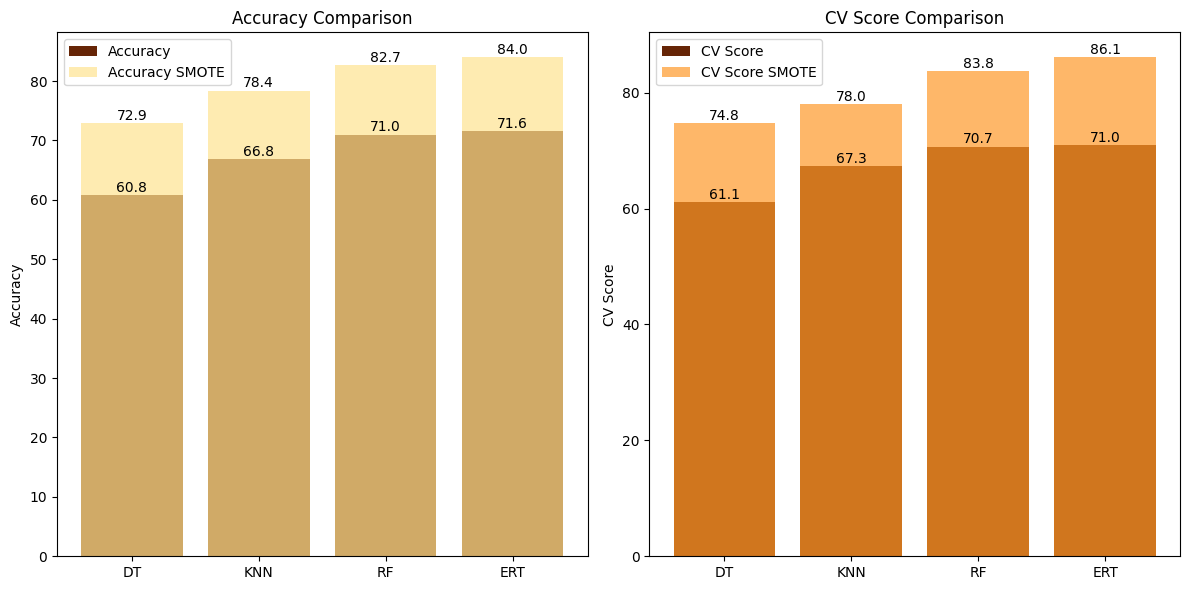

In [235]:
plt.figure(figsize=(12, 6))

# Plot Accuracy Histograms
plt.subplot(1, 2, 1)
bars_accuracy = plt.bar(results_df['Model'], results_df['Accuracy'], color='#662506', label='Accuracy')
bars_smote_accuracy = plt.bar(results_df['Model'], results_df['Accuracy with SMOTE'], color='#fee391', alpha=0.7, label='Accuracy SMOTE')

# Add text annotations
for bar in bars_accuracy:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

for bar in bars_smote_accuracy:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

# Plot CV Score Histograms
plt.subplot(1, 2, 2)
bars_cv = plt.bar(results_df['Model'], results_df['CV Score'], color='#662506', label='CV Score')
bars_smote_cv = plt.bar(results_df['Model'], results_df['CV Score with SMOTE'], color='#fe9929', alpha=0.7, label='CV Score SMOTE')
 
# Add text annotations
for bar in bars_cv:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

for bar in bars_smote_cv:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.ylabel('CV Score')
plt.title('CV Score Comparison')
plt.legend()

plt.tight_layout()
plt.show()


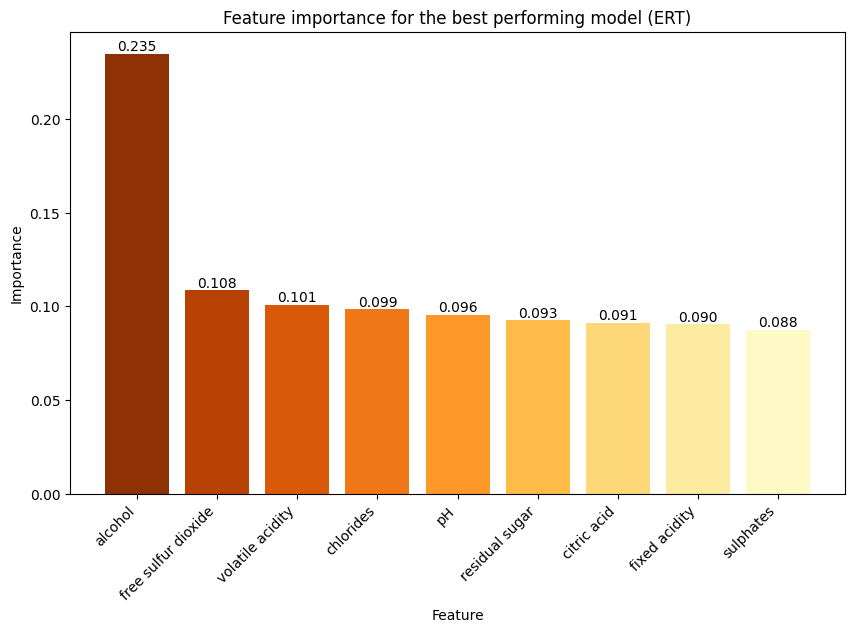

In [239]:
# Feature importance for our best model

model = ExtraTreesClassifier()
x_train_smote, x_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.25, random_state=42)
model.fit(x_train_smote, y_train_smote)

# Get feature importances
feature_importance = model.feature_importances_

# Get feature names
feature_names = X_smote.columns

# Sort indices in descending order
indices = np.argsort(feature_importance)[::-1]

palette = sns.color_palette("YlOrBr", n_colors=9)[::-1]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(feature_importance)), feature_importance[indices], align="center", color=palette)
plt.xticks(range(len(feature_importance)), feature_names[indices], rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importance for the best performing model (ERT)")

# Add numbers above the bars
for bar, value in zip(bars, feature_importance[indices]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.3f}', ha='center', va='bottom')

plt.show()


### 4. *CONCLUSIONS*

- Out of all the classifiers, Extra tress (ERTs) shows the best results for the dataset, achieving 86.1% score, surpassing initial model performance by 15%.

- Without balancing the data, the advanced model displays poor results.

- Alcohol is the major driver for white wine quality, followed by free sulfur dioxide and volatile acidity. 